# Environnement Kaggle

---
# 1. Paramètrage environnement et import des données

In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
plt.style.use("default")

from skimage import exposure
from skimage.restoration import denoise_tv_chambolle

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.callbacks import EarlyStopping

import os

In [9]:
def preprocessing_image(image):
    #image = exposure.equalize_adapthist(image)
    image = denoise_tv_chambolle(image, weight=0.1, multichannel=True)
    return image

def plot_result_fitting(history):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

    ax[0].plot(history.history['accuracy'], label='accuracy')
    ax[0].plot(history.history['val_accuracy'], label = 'val_accuracy')
    ax[0].set_title('Evolution de la précision')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['loss'], label='loss')
    ax[1].plot(history.history['val_loss'], label = 'val_loss')
    ax[1].set_title('Evolution de la fonction de perte')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.savefig('./cnn_retention_map.png',
                transparent=True)
    
    return None

In [10]:
dogs_lst = []
for dirname, _, filenames in os.walk('../input/stanford-dogs-dataset/images'):
    for filename in filenames:
        dogs_lst.append(os.path.join(dirname, filename))

# Je stocke dans un dataframe
dogs_raw = pd.DataFrame(dogs_lst, columns=['uri'])

# J'extrais la race
dogs_raw['breeds'] = dogs_raw.uri.str.split('/').str.get(5).str.slice(10)

dogs = dogs_raw

dogs

,uri,breeds
0,../input/stanford-dogs-dataset/images/Images/n...,Weimaraner
1,../input/stanford-dogs-dataset/images/Images/n...,Weimaraner
2,../input/stanford-dogs-dataset/images/Images/n...,Weimaraner
3,../input/stanford-dogs-dataset/images/Images/n...,Weimaraner
4,../input/stanford-dogs-dataset/images/Images/n...,Weimaraner
...,...,...
20575,../input/stanford-dogs-dataset/images/Images/n...,Lhasa
20576,../input/stanford-dogs-dataset/images/Images/n...,Lhasa
20577,../input/stanford-dogs-dataset/images/Images/n...,Lhasa
20578,../input/stanford-dogs-dataset/images/Images/n...,Lhasa


---
# 3. Préparation des données

In [11]:
# Séparation des données d'entrainements et de tests
train, test = train_test_split(dogs, test_size=0.2, random_state=42)

In [12]:
# Génération du jeu d'entrainement
# Séparation des données d'entrainement et de validations
datagen = ImageDataGenerator(
            rescale=1/255,
            validation_split=0.2,
            preprocessing_function=preprocessing_image)

train_train = datagen.flow_from_dataframe(
              train,
              x_col = 'uri',
              y_col = 'breeds',
              seed=123,
              subset='training'
            )
val_train = datagen.flow_from_dataframe(
              train,
              x_col = 'uri',
              y_col = 'breeds',
              seed=123,
              subset='validation'
            )

# Génération du jeu de test
datagen_test = ImageDataGenerator(
                    rescale=1/255)

test = datagen_test.flow_from_dataframe(
              test,
              x_col = 'uri',
              y_col = 'breeds',
              seed=123,
            )

Found 13172 validated image filenames belonging to 120 classes.
Found 3292 validated image filenames belonging to 120 classes.
Found 4116 validated image filenames belonging to 120 classes.


---
# 4. Formation du CNN

In [13]:
model = Sequential()

# Base d'un CNN
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

# Spécifique au données
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(len(train_train.class_indices), activation='softmax'))

# Résumé du modèle
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)           

Epoch 1/100
412/412 [==============================] - 257s 624ms/step - loss: 0.0482 - accuracy: 0.0147 - val_loss: 0.0470 - val_accuracy: 0.0264
Epoch 2/100
412/412 [==============================] - 236s 574ms/step - loss: 0.0425 - accuracy: 0.1200 - val_loss: 0.0467 - val_accuracy: 0.0498
Epoch 3/100
412/412 [==============================] - 235s 570ms/step - loss: 0.0231 - accuracy: 0.5149 - val_loss: 0.0613 - val_accuracy: 0.0437
Epoch 4/100
412/412 [==============================] - 354s 859ms/step - loss: 0.0065 - accuracy: 0.8707 - val_loss: 0.0936 - val_accuracy: 0.0480
Epoch 5/100
412/412 [==============================] - 236s 573ms/step - loss: 0.0024 - accuracy: 0.9626 - val_loss: 0.1167 - val_accuracy: 0.0416
Epoch 6/100
412/412 [==============================] - 234s 568ms/step - loss: 0.0013 - accuracy: 0.9863 - val_loss: 0.1302 - val_accuracy: 0.0419
Epoch 7/100
412/412 [==============================] - 235s 570ms/step - loss: 0.0011 - accuracy: 0.9908 - val_loss: 0

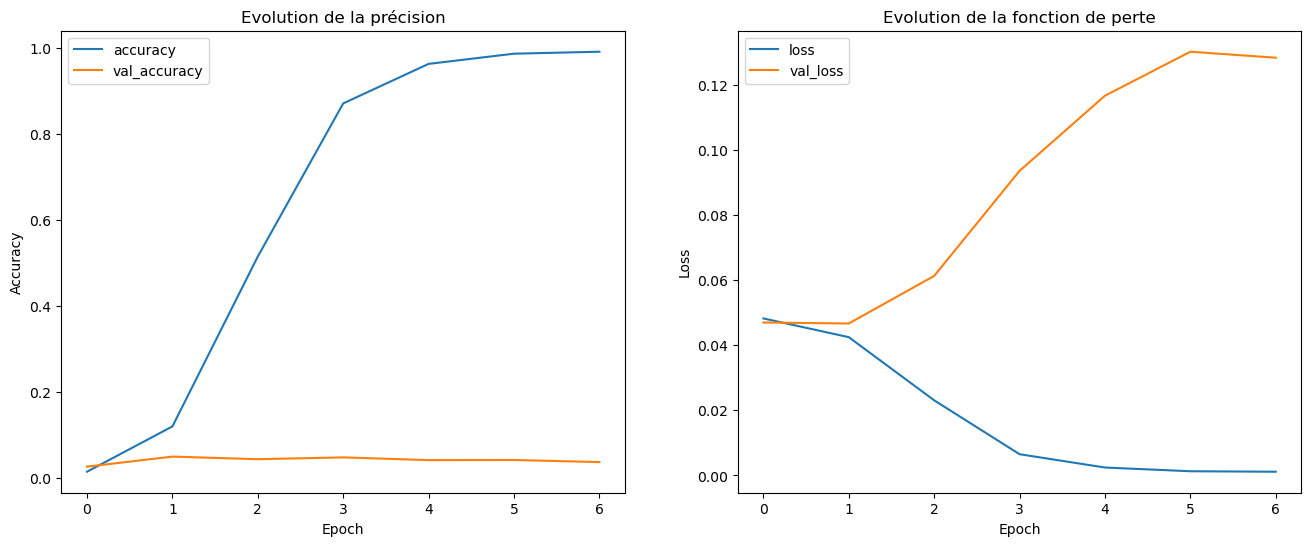

In [14]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping_monitor = EarlyStopping(patience=5)

history = model.fit(train_train, validation_data=val_train, epochs=100, callbacks = [early_stopping_monitor])

plot_result_fitting(history)

---
# 5. Evaluation

In [15]:
model.evaluate(test)

129/129 [==============================] - 24s 187ms/step - loss: 0.1284 - accuracy: 0.0345


[0.12836714088916779, 0.03449951484799385]

In [16]:
model.layers

In [17]:
conv1 = model.layers[0]
weights1 = conv1.get_weights()
len(weights1)

2

In [18]:
kernels1 = weights1[0]
kernels1.shape

(3, 3, 3, 32)

In [19]:
kernel1_1 = kernels1[:, :, 0, 0]
kernel1_1.shape

(3, 3)

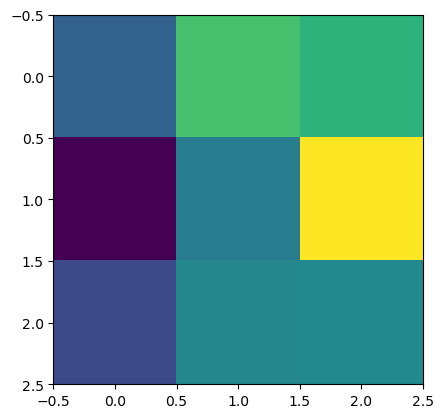

In [20]:
plt.imshow(kernel1_1)